In [1]:
# enable reloading
%load_ext autoreload
# all the modules should be reloaded before executing the code
%autoreload 2


In [2]:
from pathlib import Path
from typing import Annotated, Literal

import rootutils
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, SystemMessage
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.types import Command, interrupt
from loguru import logger
from pydantic import BaseModel

rootutils.setup_root(search_from=str(Path.cwd().parent), indicator=[".git", "pyproject.toml"], pythonpath=True)
from src.agent.my_mcps import mcp_config


In [3]:
"""
Utility functions for context engineering notebooks.
"""

from rich.console import Console
from rich.panel import Panel
import json

console = Console()


def format_message_content(message):
    """Convert message content to displayable string"""
    if isinstance(message.content, str):
        return message.content
    elif isinstance(message.content, list):
        # Handle complex content like tool calls
        parts = []
        for item in message.content:
            if item.get("type") == "text":
                parts.append(item["text"])
            elif item.get("type") == "tool_use":
                parts.append(f"\n🔧 Tool Call: {item['name']}")
                parts.append(f"   Args: {json.dumps(item['input'], indent=2)}")
        return "\n".join(parts)
    else:
        return str(message.content)


def format_messages(messages):
    """Format and display a list of messages with Rich formatting"""
    for m in messages:
        msg_type = m.__class__.__name__.replace("Message", "")
        content = format_message_content(m)

        if msg_type == "Human":
            console.print(Panel(content, title="🧑 Human", border_style="blue"))
        elif msg_type == "Ai":
            console.print(Panel(content, title="🤖 Assistant", border_style="green"))
        elif msg_type == "Tool":
            console.print(Panel(content, title="🔧 Tool Output", border_style="yellow"))
        else:
            console.print(Panel(content, title=f"📝 {msg_type}", border_style="white"))


In [4]:
from langgraph.graph import MessagesState


class States(MessagesState):
    """State of conversation between Agent and User."""

    # messages: Annotated[list[BaseMessage], add_messages] = []


protected_tools: list[str] = ["create_directory", "edit_file", "write_file"]

In [5]:
client = MultiServerMCPClient(connections=mcp_config["mcpServers"])
tools = await client.get_tools()

In [6]:
from langchain_ollama import ChatOllama
from langchain_perplexity import ChatPerplexity
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash").bind_tools(tools)

# llm = ChatPerplexity(model="sonar-pro", temperature=0)
# llm = ChatOllama(model="qwen3:8b", temperature=0).bind_tools(tools)
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(
#     model="gpt-4.1-mini-2025-04-14",
#     temperature=0.1,
# ).bind_tools(tools)

llm.invoke("hii how are you ? ")

Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is

AIMessage(content='I am doing well, thank you for asking! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--cdddfd95-88f6-467a-a229-e3edfd1774c5-0', usage_metadata={'input_tokens': 690, 'output_tokens': 18, 'total_tokens': 708, 'input_token_details': {'cache_read': 0}})

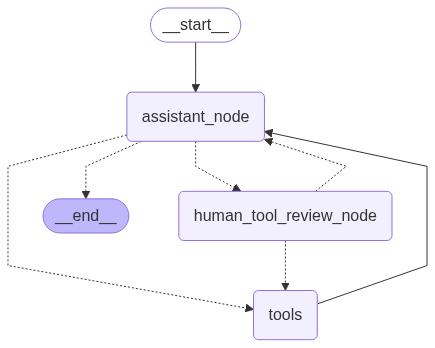

In [7]:
from langgraph.checkpoint.memory import MemorySaver


def human_tool_review_node(
    state: States,
) -> Command[Literal["tools", "assistant_node"]]:
    """Node is a placeholder for the human to review the final report generation process to verify proper tool call checks before tools are called by the agent."""
    print("[INFO] human_tool_review_node called")
    last_message = state["messages"][-1]

    # Ensure we have a valid AI message with tool calls
    if not isinstance(last_message, AIMessage) or not last_message.tool_calls:
        msg = "human_tool_review_node called without valid tool calls"
        logger.error(msg)
        raise ValueError(msg)

    tool_call = last_message.tool_calls[-1]

    # Stop graph execution and wait for human input
    human_review: dict = interrupt(
        {"message": "Your input is required for the following tool:", "tool_call": tool_call},
    )
    review_action = human_review.get("action")
    review_data = human_review.get("data")

    if review_action == "accept":
        return Command(
            goto="tools",
        )
    return Command(
        goto="assistant_node",
        update={
            "messages": [
                HumanMessage(content=review_data),
            ],
        },
    )


def assistant_node(state: States) -> States:
    print("[INFO] assistant_node called")
    response = llm.invoke(
        [
            SystemMessage(
                content="You are a helpful assistant. You have access to the local filesystem but only within an approved directory. The approved directory is /projects/workspace and all paths must begin with /projects/workspace/. You must use /project/workspace/generated_example directory. if directory does not exists then create it and then give a good name of the <file_name>.md file (for example sw_design.md) and save the generated report in /project/workspace/generated_example directory.",
            ),
            *state["messages"],
        ],
    )
    state["messages"] = [*state["messages"], response]
    return state


def router(state: States) -> str:
    print("[INFO] router called")
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        if any(tool_call["name"] in protected_tools for tool_call in last_message.tool_calls):
            return "human_tool_review_node"
        return "tools"
    return END


builder = StateGraph(States)

builder.add_node("assistant_node", assistant_node)
builder.add_node("human_tool_review_node", human_tool_review_node)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant_node")
builder.add_conditional_edges("assistant_node", router, ["tools", "human_tool_review_node", END])
builder.add_edge("tools", "assistant_node")

graph = builder.compile(checkpointer=MemorySaver())
graph

In [8]:
_input = {
    "messages": [
        HumanMessage(
            content="Generate a report on the project planning process. I don't know where to start, i want to create simple chatbot using langgraph. i am testing that you can use filesystem or not. simply generate a report without asking further question.",
        ),
    ],
}

In [9]:
# Thread
from langchain_core.messages import AIMessageChunk

thread = {"configurable": {"thread_id": "1"}}


async def test():
    async for stream_mode, chunk in graph.astream(_input, thread, stream_mode=["updates", "messages"]):
        # format_messages(event["messages"])  # event["messages"][-1].pretty_print()
        # if stream_mode == "updates":
        #     graph_name = list(chunk.keys())[0]
        #     print(graph_name)
        #     message = chunk[graph_name]["messages"][-1]
        #     yield message
        if stream_mode == "messages":  # TODO: grab graph name here and use token streaming from messages
            message, metadata = chunk
            subgraph_name = metadata["langgraph_node"]
            if isinstance(message, AIMessageChunk):
                if message.response_metadata:
                    finish_reason = message.response_metadata.get("finish_reason", "")
                    if finish_reason == "tool_calls":
                        yield "\n\n", subgraph_name

                if message.tool_call_chunks:
                    tool_chunk = message.tool_call_chunks[0]

                    tool_name = tool_chunk.get("name", "")
                    args = tool_chunk.get("args", "")

                    if tool_name:
                        tool_call_str = f"\n\n< TOOL CALL: {tool_name} >\n\n"
                    if args:
                        tool_call_str = args

                    yield tool_call_str, subgraph_name
                else:
                    yield message.content, subgraph_name

In [10]:
async for response, subgraph in test():
    # if isinstance(response, dict):
    print(response)
    # keys = list(response.keys())
    # graph_name = keys[0]
    # print(graph_name)
    # message = response[graph_name]["messages"][-1]
    # print(message.content)


Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is

[INFO] assistant_node called
{"path": "/projects/workspace/generated_example"}
[INFO] router called
[INFO] human_tool_review_node called


In [11]:
graph.get_state(config=thread)


StateSnapshot(values={'messages': [HumanMessage(content="Generate a report on the project planning process. I don't know where to start, i want to create simple chatbot using langgraph. i am testing that you can use filesystem or not. simply generate a report without asking further question.", additional_kwargs={}, response_metadata={}, id='2c6c8bb8-9631-43b8-a043-93449e8869ab'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'create_directory', 'arguments': '{"path": "/projects/workspace/generated_example"}'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--9c1c6aa7-0533-4097-9e89-e0e7548a0264', tool_calls=[{'name': 'create_directory', 'args': {'path': '/projects/workspace/generated_example'}, 'id': '5e116b14-5090-49cb-81e7-a461f1c96381', 'type': 'tool_call'}], usage_metadata={'input_tokens': 832, 'output_tokens': 12, 'total_tokens': 844, 'input_token_details': {'cache_read': 0}})]}, next=('human_tool_r

In [12]:
response


'{"path": "/projects/workspace/generated_example"}'

In [13]:
# new_state = graph.get_state(thread).values
# for m in new_state["messages"]:
#     m.pretty_print()
# async for event in graph.astream(_input, thread, stream_mode="values"):
#     event["messages"][-1].pretty_print()


In [17]:
# graph.update_state(
#     thread,
#     {"messages": [HumanMessage(content="accept")]},
# )
# _input = {"messages": [HumanMessage(content="accept")]}

# new_state = graph.get_state(thread).values
# for m in new_state["messages"]:
#     m.pretty_print()
async for event in graph.astream(Command(resume={"action": "accept", "data": ""}), thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  write_file (98b34f4b-083d-437a-a979-afabeb09d3f4)
 Call ID: 98b34f4b-083d-437a-a979-afabeb09d3f4
  Args:
    path: /projects/workspace/generated_example/project_plan.md
    content: # Project Plan: Simple Chatbot with LangGraph

## 1. Project Overview

This project aims to create a simple chatbot using LangGraph. The chatbot will be designed to provide basic conversational abilities and demonstrate the fundamental concepts of LangGraph.

## 2. Goals

*   Develop a functional chatbot using LangGraph.
*   Implement basic conversational flow.
*   Demonstrate the use of LangGraph's core features.
*   Ensure the chatbot can handle simple user inputs and provide relevant responses.

## 3. Scope

*   The chatbot will focus on a single, specific domain (e.g., answering questions about a specific topic).
*   The chatbot will be limited to text-based interactions.
*   The project will not include advan

Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is

================================= Tool Message =================================
Name: write_file

Successfully wrote to /projects/workspace/generated_example/project_plan.md
[INFO] assistant_node called
[INFO] router called
================================== Ai Message ==================================

I have created a project plan report and saved it to `/projects/workspace/generated_example/project_plan.md`.


In [15]:
async for event in graph.astream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()


================================== Ai Message ==================================
Tool Calls:
  write_file (98b34f4b-083d-437a-a979-afabeb09d3f4)
 Call ID: 98b34f4b-083d-437a-a979-afabeb09d3f4
  Args:
    path: /projects/workspace/generated_example/project_plan.md
    content: # Project Plan: Simple Chatbot with LangGraph

## 1. Project Overview

This project aims to create a simple chatbot using LangGraph. The chatbot will be designed to provide basic conversational abilities and demonstrate the fundamental concepts of LangGraph.

## 2. Goals

*   Develop a functional chatbot using LangGraph.
*   Implement basic conversational flow.
*   Demonstrate the use of LangGraph's core features.
*   Ensure the chatbot can handle simple user inputs and provide relevant responses.

## 3. Scope

*   The chatbot will focus on a single, specific domain (e.g., answering questions about a specific topic).
*   The chatbot will be limited to text-based interactions.
*   The project will not include advan

In [16]:
# from langchain.chat_models import init_chat_model

# model_shell = init_chat_model(
#     configurable_fields=("model", "max_tokens"),
# )

# report_generator_config = {
#     "model": "ollama:qwen3:8b",
# }
# report_generator_model = model_shell.with_config(report_generator_config)
# report_generator_model.invoke("hello world")